# Logistic Regression

In diesem Notebook erstellen wir eine `Baseline` mit Logistic Regression.
Wir verwenden dabei alle Features (Pixel-Farbkanal-Intensität) **ohne** Preprocessing (wie `Dimensions-Reduktion`).

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

import pickle

import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import numpy as np

from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
def plot_confusion_matrix(y_true: any, y_pred: any):
    labels = np.unique(y_true)
    fig = plt.figure(figsize=(len(labels), len(labels)))
    ConfusionMatrixDisplay(
      confusion_matrix=confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels, normalize='all'),
      display_labels=labels
    ).plot(ax=fig.gca(), cmap="BuPu", xticks_rotation='vertical', include_values=True)
    plt.show()

# Prepare data

In [3]:
# Load the data and split into features and labels
with open('../data/train.pkl', 'rb') as f:
    data_train = pickle.load(f)
X_data = data_train["images"]
y_data = data_train["labels"]

In [4]:
# Split features and labels into train (X_train, y_train) and validation set (X_val, y_val).
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

# Logistic Regression

Training und Anwendung einer `Logistic Regression` auf allen Features.
Für die `Logistic Regression` müssen wir die 3-dimensionalen Bilder (32, 32, 3) zu 1-dimensionalen Feature-Vektoren transformieren mittels `reshape`.

In [5]:
%%time

lr = LogisticRegression()

# reshape flattens the image
lr.fit(X_train.reshape(-1, 32 * 32 * 3), y_train)

y_train_hat = lr.predict(X_train.reshape(-1, 32 * 32 * 3))
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = lr.predict(X_val.reshape(-1, 32 * 32 * 3))
print("Val:   ", accuracy_score(y_val_hat, y_val))

/Users/beni/Documents/Kennwerte/IdeaProjects/cas_machine_learning_cifar10/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train:  0.4294133333333333
Val:    0.4044
CPU times: user 7min 48s, sys: 31.6 s, total: 8min 19s
Wall time: 1min 56s


Zufälliges raten hätte eine erwartete Genauigkeit von 10%.
Unser erstes Modell hat eine Genauigkeit von 40% auf dem Validation Set und damit schon einmal deutlich besser als zufälliges raten.

Wir erhalten eine Warnung: `STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.`.
Diese Warnung bedeutet, dass die Logistic Regression noch nicht zum globalen Minimum konvergiert ist.
Sprich, wir könnten die Logistic Regression weiter trainieren und sie wird sich auf dem `Trainings Set` noch verbessern.
Dies kann man über den Parameter `max_iter` einstellen.

Schauen wir aber zuerst die `Confusion Matrix` an, um festzustellen, wo wir Fehler machen.

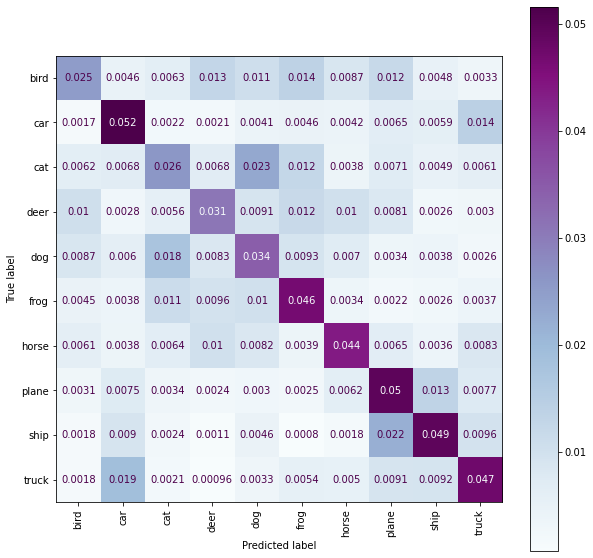

In [6]:
plot_confusion_matrix(y_true=y_val, y_pred=y_val_hat)

Grundsätzlich machen wir noch einige Fehler. Wir stellen fest, dass die Verteilung-Fehler aber intuitive Sinn ergibt.

Wir visualisieren hier noch 100 Bilder aus dem `Validation Set` mit unser vorhergesagten Klasse.

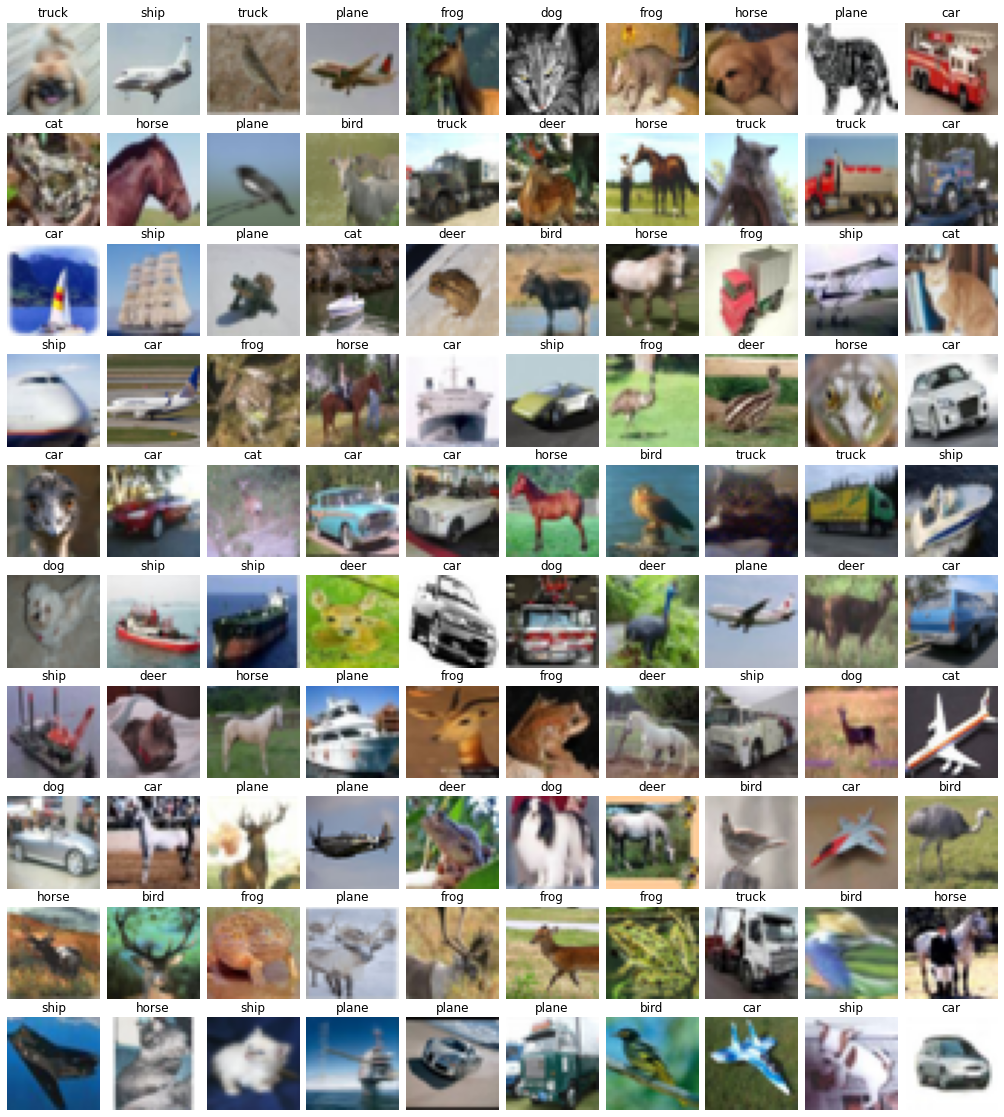

In [8]:
fig = plt.figure(figsize=(20., 20.))

grid = ImageGrid(fig, 111,
    nrows_ncols=(10, 10),
    axes_pad=(0.1, 0.25),
)

idx = np.arange(y_data.size)
np.random.shuffle(idx)

y_data_idx_pred = lr.predict(X_data[idx].reshape(-1, 32 * 32 * 3))

for ax, im, label in zip(grid, X_data[idx], y_data_idx_pred):
    ax.set_title(label)
    ax.axis('off')
    ax.imshow(im)

plt.show()

## Behandlung von `STOP: TOTAL NO. of ITERATIONS REACHED LIMIT`

Schauen wir uns nun an, was passiert, wenn wir den Parameter `max_iter` erhöhen.
Im folgenden Code setzen wir die `max_iter=1000`:

In [ ]:
%%time

lr_1k = LogisticRegression(max_iter=1000)
lr_1k.fit(X_train.reshape(-1, 32 * 32 * 3), y_train)

y_train_hat = lr_1k.predict(X_train.reshape(-1, 32 * 32 * 3))
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = lr_1k.predict(X_val.reshape(-1, 32 * 32 * 3))
print("Val:   ", accuracy_score(y_val_hat, y_val))

Wir sehen, dass wir uns auf dem `Training Set` verbessern, aber anfangen uns auf dem `Validation Set` zu verschlechtern, ein Hinweis auf `Overfitting`.
Zudem sind wir immer noch nicht konvergiert, sprich müssten `max_iter` weiter erhöhen.

# Predict classes for test set

If we are happy with the performance of our model on the validation set, we can apply it to the test set.

In [ ]:
with open('../data/test.pkl', 'rb') as f:
    X_test = pickle.load(f)

In [ ]:
y_test_pred = lr.predict(X_test.reshape(-1, 32 * 32 * 3))
y_test_pred_df = pd.DataFrame(y_test_pred, columns=['label'])

To submit the predictions to Kaggle we write them into a .csv file, which you can manually submit.

In [ ]:
y_test_pred_df.to_csv('../out/logistic_regression.csv', header=True, index_label='id')

## Nächste Schritte

Die Logistic Regression konvergiert nicht richtig, da wir **viele Datenpunkte (37500)** und **viele Features (3072)** haben.
Dafür haben wir im Theorie Teil die `Dimensions-Reduktion` mittels `PCA` (oder `NMF`) kennengelernt.
Mit `PCA` kann die Anzahl Features von 3072 beispielsweise auf 200 PC-Features reduziert werden.
Auf diesen 200 PC-Features können wir dann eine `Logistic Regression` oder auch eine `LinearSVC` trainieren, ohne dass wir in Performanz-Probleme laufen.